In [1]:
import torch_geometric
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import defaultdict
import os
import itertools
import sys
folder_path = './'
sys.path.insert(1, folder_path)
from train_pipeline import train
from eval_pipeline import eval
import seaborn
seaborn.set_style('darkgrid')
plt.rcParams.update({'font.size': 14, 'lines.markersize': 8, 'lines.linewidth': 2})

In [2]:
random_seeds = [13531, 24642, 35753]
k_range = [4, 6, 8, 10] # number of transmitter-receiver pairs for training
num_train_samples_range = [32, 64, 128, 256] # number of training samples
num_test_samples = 256 # number of test samples
modes = ['Supervised', 'Unsupervised'] # modes of training
figsize = (8, 6)
os.makedirs(folder_path + 'saved_training_data/results', exist_ok=True)
os.makedirs(folder_path + 'saved_training_data/models', exist_ok=True)

In [3]:
# perform training
for k, num_train_samples, mode, seed in itertools.product(k_range, num_train_samples_range, modes, random_seeds):
    num_samples = {'train': num_train_samples, 'test': num_test_samples}
    experiment_name = 'k_train_{}_num_train_samples_{}_mode_{}_seed_{}'.format(k, str(num_samples), mode, seed)
    print('Now running experiment \"{}\" ...'.format(experiment_name))
    all_epoch_results, best_model = train(k, num_samples, mode, seed)
    torch.save(all_epoch_results, folder_path + 'saved_training_data/results/{}.json'.format(experiment_name))
    torch.save(best_model, folder_path + 'saved_training_data/models/{}.pt'.format(experiment_name))

Now running experiment "k_train_4_num_train_samples_{'train': 32, 'test': 256}_mode_Supervised_seed_13531" ...


  0%|          | 0/1 [00:00<?, ?it/s]

Now running experiment "k_train_4_num_train_samples_{'train': 32, 'test': 256}_mode_Supervised_seed_24642" ...


100%|██████████| 1/1 [00:00<00:00,  7.47it/s]

Now running experiment "k_train_4_num_train_samples_{'train': 32, 'test': 256}_mode_Supervised_seed_35753" ...



100%|██████████| 1/1 [00:00<00:00,  7.98it/s]

Now running experiment "k_train_4_num_train_samples_{'train': 32, 'test': 256}_mode_Unsupervised_seed_13531" ...



  0%|          | 0/1 [00:00<?, ?it/s]

Now running experiment "k_train_4_num_train_samples_{'train': 32, 'test': 256}_mode_Unsupervised_seed_24642" ...


  0%|          | 0/1 [00:00<?, ?it/s]

Now running experiment "k_train_4_num_train_samples_{'train': 32, 'test': 256}_mode_Unsupervised_seed_35753" ...


100%|██████████| 1/1 [00:00<00:00,  4.05it/s]


Now running experiment "k_train_4_num_train_samples_{'train': 64, 'test': 256}_mode_Supervised_seed_13531" ...


  0%|          | 0/1 [00:00<?, ?it/s]

Now running experiment "k_train_4_num_train_samples_{'train': 64, 'test': 256}_mode_Supervised_seed_24642" ...


  0%|          | 0/1 [00:00<?, ?it/s]

Now running experiment "k_train_4_num_train_samples_{'train': 64, 'test': 256}_mode_Supervised_seed_35753" ...


100%|██████████| 1/1 [00:00<00:00,  7.55it/s]

Now running experiment "k_train_4_num_train_samples_{'train': 64, 'test': 256}_mode_Unsupervised_seed_13531" ...



  0%|          | 0/1 [00:00<?, ?it/s]

Now running experiment "k_train_4_num_train_samples_{'train': 64, 'test': 256}_mode_Unsupervised_seed_24642" ...


  0%|          | 0/1 [00:00<?, ?it/s]

Now running experiment "k_train_4_num_train_samples_{'train': 64, 'test': 256}_mode_Unsupervised_seed_35753" ...


100%|██████████| 1/1 [00:00<00:00,  3.26it/s]


Now running experiment "k_train_4_num_train_samples_{'train': 128, 'test': 256}_mode_Supervised_seed_13531" ...


  0%|          | 0/1 [00:00<?, ?it/s]

Now running experiment "k_train_4_num_train_samples_{'train': 128, 'test': 256}_mode_Supervised_seed_24642" ...


  0%|          | 0/1 [00:00<?, ?it/s]

Now running experiment "k_train_4_num_train_samples_{'train': 128, 'test': 256}_mode_Supervised_seed_35753" ...


  0%|          | 0/1 [00:00<?, ?it/s]

Now running experiment "k_train_4_num_train_samples_{'train': 128, 'test': 256}_mode_Unsupervised_seed_13531" ...


  0%|          | 0/1 [00:00<?, ?it/s]

Now running experiment "k_train_4_num_train_samples_{'train': 128, 'test': 256}_mode_Unsupervised_seed_24642" ...


  0%|          | 0/1 [00:00<?, ?it/s]

Now running experiment "k_train_4_num_train_samples_{'train': 128, 'test': 256}_mode_Unsupervised_seed_35753" ...


100%|██████████| 1/1 [00:00<00:00,  4.09it/s]


Now running experiment "k_train_4_num_train_samples_{'train': 256, 'test': 256}_mode_Supervised_seed_13531" ...


  0%|          | 0/1 [00:00<?, ?it/s]

Now running experiment "k_train_4_num_train_samples_{'train': 256, 'test': 256}_mode_Supervised_seed_24642" ...


  0%|          | 0/1 [00:00<?, ?it/s]

Now running experiment "k_train_4_num_train_samples_{'train': 256, 'test': 256}_mode_Supervised_seed_35753" ...


  0%|          | 0/1 [00:00<?, ?it/s]

Now running experiment "k_train_4_num_train_samples_{'train': 256, 'test': 256}_mode_Unsupervised_seed_13531" ...


  0%|          | 0/1 [00:00<?, ?it/s]

Now running experiment "k_train_4_num_train_samples_{'train': 256, 'test': 256}_mode_Unsupervised_seed_24642" ...


100%|██████████| 1/1 [00:00<00:00,  3.53it/s]


Now running experiment "k_train_4_num_train_samples_{'train': 256, 'test': 256}_mode_Unsupervised_seed_35753" ...


100%|██████████| 1/1 [00:00<00:00,  3.12it/s]


Now running experiment "k_train_6_num_train_samples_{'train': 32, 'test': 256}_mode_Supervised_seed_13531" ...


  0%|          | 0/1 [00:00<?, ?it/s]

Now running experiment "k_train_6_num_train_samples_{'train': 32, 'test': 256}_mode_Supervised_seed_24642" ...


  0%|          | 0/1 [00:00<?, ?it/s]

Now running experiment "k_train_6_num_train_samples_{'train': 32, 'test': 256}_mode_Supervised_seed_35753" ...


  0%|          | 0/1 [00:00<?, ?it/s]

Now running experiment "k_train_6_num_train_samples_{'train': 32, 'test': 256}_mode_Unsupervised_seed_13531" ...


  0%|          | 0/1 [00:00<?, ?it/s]

Now running experiment "k_train_6_num_train_samples_{'train': 32, 'test': 256}_mode_Unsupervised_seed_24642" ...


  0%|          | 0/1 [00:00<?, ?it/s]

Now running experiment "k_train_6_num_train_samples_{'train': 32, 'test': 256}_mode_Unsupervised_seed_35753" ...


100%|██████████| 1/1 [00:00<00:00,  4.23it/s]


Now running experiment "k_train_6_num_train_samples_{'train': 64, 'test': 256}_mode_Supervised_seed_13531" ...


  0%|          | 0/1 [00:00<?, ?it/s]

Now running experiment "k_train_6_num_train_samples_{'train': 64, 'test': 256}_mode_Supervised_seed_24642" ...


  0%|          | 0/1 [00:00<?, ?it/s]

Now running experiment "k_train_6_num_train_samples_{'train': 64, 'test': 256}_mode_Supervised_seed_35753" ...


100%|██████████| 1/1 [00:00<00:00,  7.41it/s]

Now running experiment "k_train_6_num_train_samples_{'train': 64, 'test': 256}_mode_Unsupervised_seed_13531" ...



  0%|          | 0/1 [00:00<?, ?it/s]

Now running experiment "k_train_6_num_train_samples_{'train': 64, 'test': 256}_mode_Unsupervised_seed_24642" ...


  0%|          | 0/1 [00:00<?, ?it/s]

Now running experiment "k_train_6_num_train_samples_{'train': 64, 'test': 256}_mode_Unsupervised_seed_35753" ...


100%|██████████| 1/1 [00:00<00:00,  3.41it/s]


Now running experiment "k_train_6_num_train_samples_{'train': 128, 'test': 256}_mode_Supervised_seed_13531" ...


  0%|          | 0/1 [00:00<?, ?it/s]

Now running experiment "k_train_6_num_train_samples_{'train': 128, 'test': 256}_mode_Supervised_seed_24642" ...


  0%|          | 0/1 [00:00<?, ?it/s]

Now running experiment "k_train_6_num_train_samples_{'train': 128, 'test': 256}_mode_Supervised_seed_35753" ...


  0%|          | 0/1 [00:00<?, ?it/s]

Now running experiment "k_train_6_num_train_samples_{'train': 128, 'test': 256}_mode_Unsupervised_seed_13531" ...


  0%|          | 0/1 [00:00<?, ?it/s]

Now running experiment "k_train_6_num_train_samples_{'train': 128, 'test': 256}_mode_Unsupervised_seed_24642" ...


  0%|          | 0/1 [00:00<?, ?it/s]

Now running experiment "k_train_6_num_train_samples_{'train': 128, 'test': 256}_mode_Unsupervised_seed_35753" ...


100%|██████████| 1/1 [00:00<00:00,  2.35it/s]


Now running experiment "k_train_6_num_train_samples_{'train': 256, 'test': 256}_mode_Supervised_seed_13531" ...


  0%|          | 0/1 [00:00<?, ?it/s]

Now running experiment "k_train_6_num_train_samples_{'train': 256, 'test': 256}_mode_Supervised_seed_24642" ...


  0%|          | 0/1 [00:00<?, ?it/s]

Now running experiment "k_train_6_num_train_samples_{'train': 256, 'test': 256}_mode_Supervised_seed_35753" ...


100%|██████████| 1/1 [00:00<00:00,  2.22it/s]


Now running experiment "k_train_6_num_train_samples_{'train': 256, 'test': 256}_mode_Unsupervised_seed_13531" ...


  0%|          | 0/1 [00:00<?, ?it/s]

Now running experiment "k_train_6_num_train_samples_{'train': 256, 'test': 256}_mode_Unsupervised_seed_24642" ...


  0%|          | 0/1 [00:00<?, ?it/s]

Now running experiment "k_train_6_num_train_samples_{'train': 256, 'test': 256}_mode_Unsupervised_seed_35753" ...


100%|██████████| 1/1 [00:00<00:00,  2.00it/s]


Now running experiment "k_train_8_num_train_samples_{'train': 32, 'test': 256}_mode_Supervised_seed_13531" ...


  0%|          | 0/1 [00:00<?, ?it/s]

Now running experiment "k_train_8_num_train_samples_{'train': 32, 'test': 256}_mode_Supervised_seed_24642" ...


  0%|          | 0/1 [00:00<?, ?it/s]

Now running experiment "k_train_8_num_train_samples_{'train': 32, 'test': 256}_mode_Supervised_seed_35753" ...


  0%|          | 0/1 [00:00<?, ?it/s]

Now running experiment "k_train_8_num_train_samples_{'train': 32, 'test': 256}_mode_Unsupervised_seed_13531" ...


  0%|          | 0/1 [00:00<?, ?it/s]

Now running experiment "k_train_8_num_train_samples_{'train': 32, 'test': 256}_mode_Unsupervised_seed_24642" ...


  0%|          | 0/1 [00:00<?, ?it/s]

Now running experiment "k_train_8_num_train_samples_{'train': 32, 'test': 256}_mode_Unsupervised_seed_35753" ...


100%|██████████| 1/1 [00:00<00:00,  4.39it/s]


Now running experiment "k_train_8_num_train_samples_{'train': 64, 'test': 256}_mode_Supervised_seed_13531" ...


  0%|          | 0/1 [00:00<?, ?it/s]

Now running experiment "k_train_8_num_train_samples_{'train': 64, 'test': 256}_mode_Supervised_seed_24642" ...


100%|██████████| 1/1 [00:00<00:00,  7.81it/s]

Now running experiment "k_train_8_num_train_samples_{'train': 64, 'test': 256}_mode_Supervised_seed_35753" ...



  0%|          | 0/1 [00:00<?, ?it/s]

Now running experiment "k_train_8_num_train_samples_{'train': 64, 'test': 256}_mode_Unsupervised_seed_13531" ...


  0%|          | 0/1 [00:00<?, ?it/s]

Now running experiment "k_train_8_num_train_samples_{'train': 64, 'test': 256}_mode_Unsupervised_seed_24642" ...


  0%|          | 0/1 [00:00<?, ?it/s]

Now running experiment "k_train_8_num_train_samples_{'train': 64, 'test': 256}_mode_Unsupervised_seed_35753" ...


100%|██████████| 1/1 [00:00<00:00,  3.42it/s]


Now running experiment "k_train_8_num_train_samples_{'train': 128, 'test': 256}_mode_Supervised_seed_13531" ...


  0%|          | 0/1 [00:00<?, ?it/s]

Now running experiment "k_train_8_num_train_samples_{'train': 128, 'test': 256}_mode_Supervised_seed_24642" ...


  0%|          | 0/1 [00:00<?, ?it/s]

Now running experiment "k_train_8_num_train_samples_{'train': 128, 'test': 256}_mode_Supervised_seed_35753" ...


  0%|          | 0/1 [00:00<?, ?it/s]

Now running experiment "k_train_8_num_train_samples_{'train': 128, 'test': 256}_mode_Unsupervised_seed_13531" ...


  0%|          | 0/1 [00:00<?, ?it/s]

Now running experiment "k_train_8_num_train_samples_{'train': 128, 'test': 256}_mode_Unsupervised_seed_24642" ...


  0%|          | 0/1 [00:00<?, ?it/s]

Now running experiment "k_train_8_num_train_samples_{'train': 128, 'test': 256}_mode_Unsupervised_seed_35753" ...


100%|██████████| 1/1 [00:00<00:00,  2.48it/s]


Now running experiment "k_train_8_num_train_samples_{'train': 256, 'test': 256}_mode_Supervised_seed_13531" ...


  0%|          | 0/1 [00:00<?, ?it/s]

Now running experiment "k_train_8_num_train_samples_{'train': 256, 'test': 256}_mode_Supervised_seed_24642" ...


  0%|          | 0/1 [00:00<?, ?it/s]

Now running experiment "k_train_8_num_train_samples_{'train': 256, 'test': 256}_mode_Supervised_seed_35753" ...


  0%|          | 0/1 [00:00<?, ?it/s]

Now running experiment "k_train_8_num_train_samples_{'train': 256, 'test': 256}_mode_Unsupervised_seed_13531" ...


  0%|          | 0/1 [00:00<?, ?it/s]

Now running experiment "k_train_8_num_train_samples_{'train': 256, 'test': 256}_mode_Unsupervised_seed_24642" ...


  0%|          | 0/1 [00:00<?, ?it/s]

Now running experiment "k_train_8_num_train_samples_{'train': 256, 'test': 256}_mode_Unsupervised_seed_35753" ...


100%|██████████| 1/1 [00:00<00:00,  2.77it/s]


Now running experiment "k_train_10_num_train_samples_{'train': 32, 'test': 256}_mode_Supervised_seed_13531" ...


  0%|          | 0/1 [00:00<?, ?it/s]

Now running experiment "k_train_10_num_train_samples_{'train': 32, 'test': 256}_mode_Supervised_seed_24642" ...


  0%|          | 0/1 [00:00<?, ?it/s]

Now running experiment "k_train_10_num_train_samples_{'train': 32, 'test': 256}_mode_Supervised_seed_35753" ...


  0%|          | 0/1 [00:00<?, ?it/s]

Now running experiment "k_train_10_num_train_samples_{'train': 32, 'test': 256}_mode_Unsupervised_seed_13531" ...


  0%|          | 0/1 [00:00<?, ?it/s]

Now running experiment "k_train_10_num_train_samples_{'train': 32, 'test': 256}_mode_Unsupervised_seed_24642" ...


  0%|          | 0/1 [00:00<?, ?it/s]

Now running experiment "k_train_10_num_train_samples_{'train': 32, 'test': 256}_mode_Unsupervised_seed_35753" ...


100%|██████████| 1/1 [00:00<00:00,  3.90it/s]


Now running experiment "k_train_10_num_train_samples_{'train': 64, 'test': 256}_mode_Supervised_seed_13531" ...


  0%|          | 0/1 [00:00<?, ?it/s]

Now running experiment "k_train_10_num_train_samples_{'train': 64, 'test': 256}_mode_Supervised_seed_24642" ...


  0%|          | 0/1 [00:00<?, ?it/s]

Now running experiment "k_train_10_num_train_samples_{'train': 64, 'test': 256}_mode_Supervised_seed_35753" ...


  0%|          | 0/1 [00:00<?, ?it/s]

Now running experiment "k_train_10_num_train_samples_{'train': 64, 'test': 256}_mode_Unsupervised_seed_13531" ...


  0%|          | 0/1 [00:00<?, ?it/s]

Now running experiment "k_train_10_num_train_samples_{'train': 64, 'test': 256}_mode_Unsupervised_seed_24642" ...


  0%|          | 0/1 [00:00<?, ?it/s]

Now running experiment "k_train_10_num_train_samples_{'train': 64, 'test': 256}_mode_Unsupervised_seed_35753" ...


100%|██████████| 1/1 [00:00<00:00,  2.89it/s]


Now running experiment "k_train_10_num_train_samples_{'train': 128, 'test': 256}_mode_Supervised_seed_13531" ...


  0%|          | 0/1 [00:00<?, ?it/s]

Now running experiment "k_train_10_num_train_samples_{'train': 128, 'test': 256}_mode_Supervised_seed_24642" ...


  0%|          | 0/1 [00:00<?, ?it/s]

Now running experiment "k_train_10_num_train_samples_{'train': 128, 'test': 256}_mode_Supervised_seed_35753" ...


  0%|          | 0/1 [00:00<?, ?it/s]

Now running experiment "k_train_10_num_train_samples_{'train': 128, 'test': 256}_mode_Unsupervised_seed_13531" ...


100%|██████████| 1/1 [00:00<00:00,  3.04it/s]


Now running experiment "k_train_10_num_train_samples_{'train': 128, 'test': 256}_mode_Unsupervised_seed_24642" ...


  0%|          | 0/1 [00:00<?, ?it/s]

Now running experiment "k_train_10_num_train_samples_{'train': 128, 'test': 256}_mode_Unsupervised_seed_35753" ...


100%|██████████| 1/1 [00:00<00:00,  3.23it/s]


Now running experiment "k_train_10_num_train_samples_{'train': 256, 'test': 256}_mode_Supervised_seed_13531" ...


  0%|          | 0/1 [00:00<?, ?it/s]

Now running experiment "k_train_10_num_train_samples_{'train': 256, 'test': 256}_mode_Supervised_seed_24642" ...


  0%|          | 0/1 [00:00<?, ?it/s]

Now running experiment "k_train_10_num_train_samples_{'train': 256, 'test': 256}_mode_Supervised_seed_35753" ...


  0%|          | 0/1 [00:00<?, ?it/s]

Now running experiment "k_train_10_num_train_samples_{'train': 256, 'test': 256}_mode_Unsupervised_seed_13531" ...


  0%|          | 0/1 [00:00<?, ?it/s]

Now running experiment "k_train_10_num_train_samples_{'train': 256, 'test': 256}_mode_Unsupervised_seed_24642" ...


100%|██████████| 1/1 [00:00<00:00,  3.03it/s]


Now running experiment "k_train_10_num_train_samples_{'train': 256, 'test': 256}_mode_Unsupervised_seed_35753" ...


100%|██████████| 1/1 [00:00<00:00,  1.64it/s]


In [4]:
# load all results
all_epoch_results = dict()
for k, num_train_samples, mode, seed in itertools.product(k_range, num_train_samples_range, modes, random_seeds):
    num_samples = {'train': num_train_samples, 'test': num_test_samples}
    experiment_name = 'k_train_{}_num_train_samples_{}_mode_{}_seed_{}'.format(k, str(num_samples), mode, seed)
    all_epoch_results[k, str(num_samples), mode, seed] = torch.load(folder_path + 'saved_training_data/results/{}.json'.format(experiment_name))
os.makedirs(folder_path + 'saved_training_data/plots', exist_ok=True)

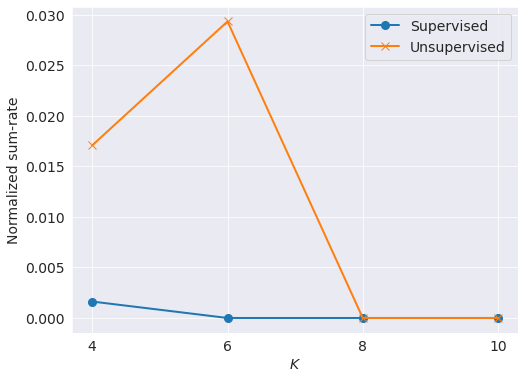

In [5]:
# performance comparison
plt.figure(figsize=figsize)
markers = ['o', 'x']
num_samples = {'train': np.max(num_train_samples_range), 'test': num_test_samples}
for i, mode in enumerate(modes):
    test_sum_rates_all_seeds = []
    for seed in random_seeds:
        test_sum_rates = []
        for k in k_range:
            res = all_epoch_results[k, str(num_samples), mode, seed]
            corresponding_test_sumrate = np.max(res['test', k, 'normalized_sum_rate'])
            test_sum_rates.append(corresponding_test_sumrate)
        test_sum_rates_all_seeds.append(test_sum_rates)
    plt.plot(k_range, np.mean(test_sum_rates_all_seeds, axis=0), label=mode, marker=markers[i])
plt.xlabel(r'$K$')
plt.ylabel('Normalized sum-rate')
plt.xticks(k_range)
plt.legend()
plt.grid(True)
plt.show()

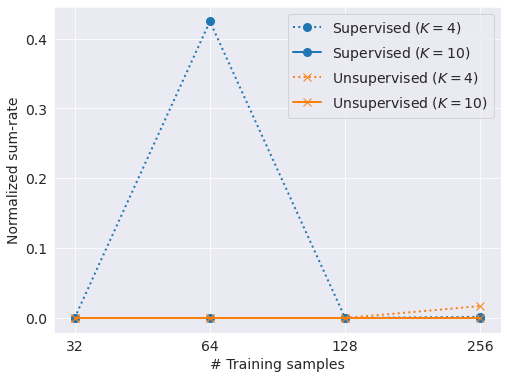

In [6]:
# sample complexity
plt.figure(figsize=figsize)
k_range_to_plot = [k_range[0], k_range[-1]]
markers = ['o', 'x']
linestyles = [':', '-']
for i, mode in enumerate(modes):
    for j, k in enumerate(k_range_to_plot):
        test_sum_rates_all_seeds = []
        for seed in random_seeds:
            test_sum_rates = []
            for num_train_samples in num_train_samples_range:
                num_samples = {'train': num_train_samples, 'test': num_test_samples}
                res = all_epoch_results[k, str(num_samples), mode, seed]
                corresponding_test_sumrate = np.max(res['test', k, 'normalized_sum_rate'])
                test_sum_rates.append(corresponding_test_sumrate)
            test_sum_rates_all_seeds.append(test_sum_rates)
        if j == 0:
            plt.plot(range(len(num_train_samples_range)), np.mean(test_sum_rates_all_seeds, axis=0), linestyles[j], label=mode+r' ($K=${})'.format(k), marker=markers[i])
        elif j == 1:
            plt.plot(range(len(num_train_samples_range)), np.mean(test_sum_rates_all_seeds, axis=0), linestyles[j], label=mode+r' ($K=${})'.format(k), marker=markers[i], color=plt.gca().lines[-1].get_color())
plt.xlabel('# Training samples')
plt.ylabel('Normalized sum-rate')
plt.xticks(range(len(num_train_samples_range)))
plt.gca().set_xticklabels(num_train_samples_range)
plt.legend()
plt.grid(True)
plt.show()

100%|██████████| 4/4 [00:00<00:00, 12.17it/s]


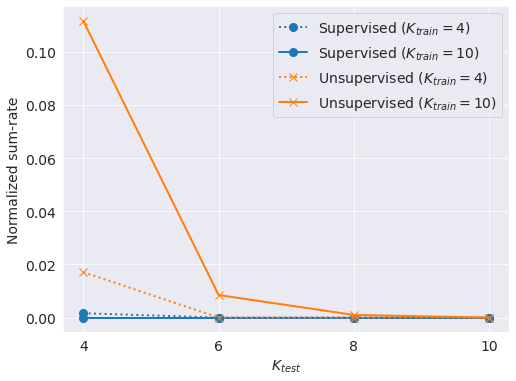

In [7]:
# generalization capability
test_seed = 12345321
plt.figure(figsize=figsize)
k_range_to_plot = [k_range[0], k_range[-1]]
k_range_to_eval = k_range#range(2, 13)
markers = ['o', 'x']
linestyles = [':', '-']
num_samples = {'train': np.max(num_train_samples_range), 'test': num_test_samples}
for i, mode in enumerate(modes):
    for j, k_train in enumerate(k_range_to_plot):
        test_sum_rates_all_seeds = []
        for seed in random_seeds:
            test_sum_rates = []
            for k_eval in tqdm(k_range_to_eval):
                if k_eval == k_train:
                    res = all_epoch_results[k_train, str(num_samples), mode, seed]
                    test_sum_rate_generalization = np.max(res['test', k_train, 'normalized_sum_rate'])
                else:
                    # load model
                    experiment_name = 'k_train_{}_num_train_samples_{}_mode_{}_seed_{}'.format(k_train, str(num_samples), mode, seed)
                    model_state_dict = torch.load(folder_path + 'saved_training_data/models/{}.pt'.format(experiment_name))
                    test_sum_rate_generalization = eval(model_state_dict, k_eval, num_test_samples, test_seed)
                test_sum_rates.append(test_sum_rate_generalization)
            test_sum_rates_all_seeds.append(test_sum_rates)
        if j == 0:
            plt.plot(k_range_to_eval, np.mean(test_sum_rates_all_seeds, axis=0), linestyles[j], label=mode+r' ($K_{train}=$' + '{})'.format(k_train), marker=markers[i])
        elif j == 1:
            plt.plot(k_range_to_eval, np.mean(test_sum_rates_all_seeds, axis=0), linestyles[j], label=mode+r' ($K_{train}=$' + '{})'.format(k_train), marker=markers[i], color=plt.gca().lines[-1].get_color())
plt.xlabel(r'$K_{test}$')
plt.ylabel('Normalized sum-rate')
plt.xticks(k_range_to_eval)
plt.legend()
plt.grid(True)
plt.show()